In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
from warnings import filterwarnings
import string
import re
import nltk
from nltk.corpus import stopwords

In [2]:
filterwarnings(action='ignore')
plt.style.use('ggplot')
pal = sns.color_palette()
matplotlib.rc('axes.formatter', useoffset=False)

In [59]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

In [60]:
train_df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


## EDA

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
train_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [7]:
train_df[train_df['question1'].isnull() == True]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [8]:
train_df[train_df['question2'].isnull() == True]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [61]:
train_df.drop(train_df[train_df['question2'].isnull() == True].index, inplace=True)
train_df.drop(train_df[train_df['question1'].isnull() == True].index, inplace=True)

In [10]:
test_df.isnull().sum()

test_id      0
question1    4
question2    6
dtype: int64

In [11]:
test_df[test_df['question1'].isnull() == True]

,test_id,question1,question2
1046690,1046690,NaN,How I what can learn android app development?
1461432,1461432,NaN,How distinct can learn android app development?
2345796,"life in dublin?""",NaN,NaN
2679111,1461432,NaN,How distinct can learn android app development?


In [67]:
test_df[test_df['question2'].isnull() == True]

,test_id,question1,question2,q1_clean,q2_clean


In [66]:
test_df[test_df['question1'].isnull()] = 'null question'
test_df[test_df['question2'].isnull()] = 'null question'

## we'll take care of that later

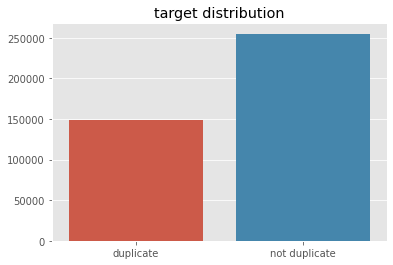

In [14]:
dist = [train_df[train_df['is_duplicate'] == 1]['is_duplicate'].count(
), train_df[train_df['is_duplicate'] == 0]['is_duplicate'].count()]

sns.barplot(x=['duplicate', 'not duplicate'], y=dist)
plt.title('target distribution')
plt.show()

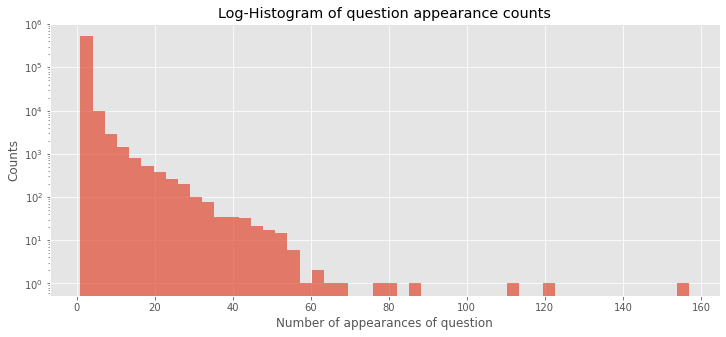

In [15]:
# question appearance count

qids = pd.Series(train_df['qid1'].tolist() + train_df['qid2'].tolist())

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50, color=pal[0], alpha=0.7)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of appearances of question')
plt.ylabel('Counts')
plt.show()

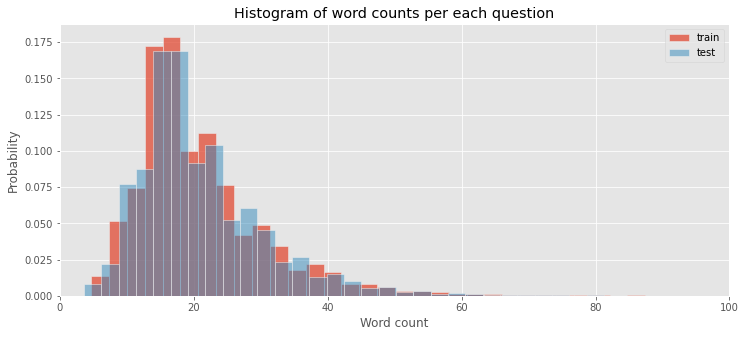

In [16]:
# word count

train_qs = pd.Series(train_df['question1'] + train_df['question2']).astype(str)
test_qs = pd.Series(test_df['question1'] + test_df['question2']).astype(str)

train_words_dist = train_qs.apply(lambda x: len(x.split(' ')))
test_words_dist = test_qs.apply(lambda x: len(x.split(' ')))

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(train_words_dist, bins=100, ax=ax,
             color=pal[0], label='train', stat='probability')
sns.histplot(test_words_dist, bins=100, ax=ax,
             color=pal[1], label='test', alpha=0.5, stat='probability')
plt.title('Histogram of word counts per each question')
plt.xlabel('Word count')
ax.set_xlim(0, 100)
plt.legend()
plt.show()

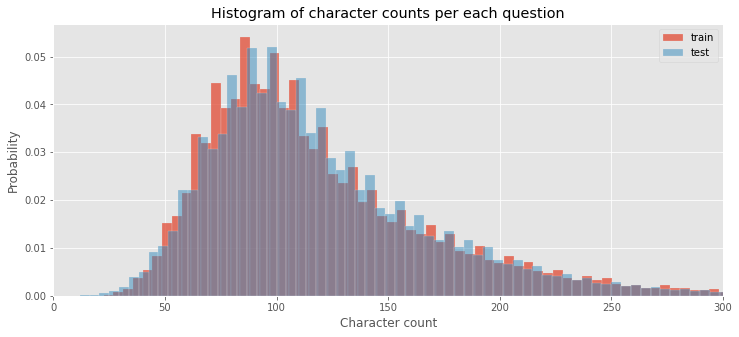

In [17]:
# character count 

train_char_count = train_qs.apply(lambda x: len(x))
test_char_count = test_qs.apply(lambda x: len(x))

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(train_char_count, bins=300, ax=ax,
             color=pal[0], label='train', stat='probability')
sns.histplot(test_char_count, bins=300, ax=ax,
             color=pal[1], label='test', alpha=0.5, stat='probability')
plt.title('Histogram of character counts per each question')
plt.xlabel('Character count')
ax.set_xlim(0, 300)
plt.legend()
plt.show()

In [18]:
# appearance of punks

puncts = string.punctuation
train_puncts_count = {}
test_puncts_count = {}
for p in puncts:
    train_puncts_count[p] = np.sum(train_qs.apply(lambda x: p in x))
    test_puncts_count[p] = np.sum(test_qs.apply(lambda x: p in x))
    
train_puncts_count = {k: v for k, v in sorted(train_puncts_count.items(), key=lambda item: item[1], reverse=True)}
test_puncts_count = {k: v for k, v in sorted(test_puncts_count.items(), key=lambda item: item[1], reverse=True)}

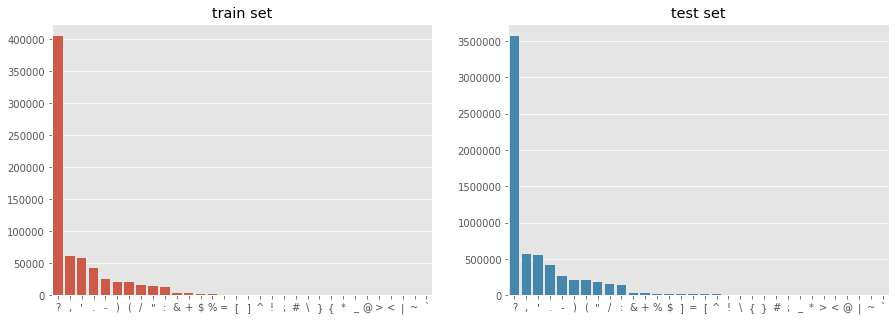

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.ticklabel_format(style='plain')

sns.barplot(x=list(train_puncts_count.keys()), y=list(train_puncts_count.values()), color=pal[0], ax=axs[0])
axs[0].set(title='train set')
sns.barplot(x=list(test_puncts_count.keys()), y=list(test_puncts_count.values()), color=pal[1], ax=axs[1])
axs[1].set(title='test set')
plt.show()

## Text cleaning

In [51]:
def decontracter(text):
    contractions = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }
    decontracted = []
    for word in text.split():
        if word in contractions:
            word = contractions[word]
        decontracted.append(word)
    text = ' '.join(decontracted)
    
    return text

In [55]:
def text_cleaner(text):
    # lower case
    text = text.lower()

    # html tags and url remover
    text = re.sub(
        r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)

    # decontracter
    text = decontracter(text)

    # punctuantions remover
    text = ''.join([word for word in text if word not in string.punctuation])

    # replacing some characters with string
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = text.replace('w/o', 'without')
    text = text.replace('w8', 'wait')
    text = text.replace("'ve", " have")
    text = text.replace("n't", " not")
    text = text.replace("'re", " are")
    text = text.replace("'ll", " will")

    # emoji remover
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    return text

In [68]:
train_df['q1_clean'] = 'temp'
train_df['q2_clean'] = 'temp'
train_df['q1_clean'] = train_df['question1'].apply(lambda x: text_cleaner(x))
train_df['q2_clean'] = train_df['question2'].apply(lambda x: text_cleaner(x))

test_df['q1_clean'] = 'temp'
test_df['q2_clean'] = 'temp'
test_df['q1_clean'] = test_df['question1'].apply(lambda x: text_cleaner(x))
test_df['q2_clean'] = test_df['question2'].apply(lambda x: text_cleaner(x))

In [70]:
test_df

,test_id,question1,question2,q1_clean,q2_clean
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,how does the surface pro himself 4 compare wit...,why did microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,should i have a hair transplant at age 24 how ...,how much cost does hair transplant require
2,2,What but is the best way to send money from Ch...,What you send money to China?,what but is the best way to send money from ch...,what you send money to china
3,3,Which food not emulsifiers?,What foods fibre?,which food not emulsifiers,what foods fibre
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,how aberystwyth start reading,how their can i start reading
...,...,...,...,...,...
3563470,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?,how do peaks tv series why did leland kill lau...,what is the most study scene in twin peaks
3563471,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?,what does be in transit mean on fedex tracking,how question fedex packages delivered
3563472,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?,what are some famous romanian drinks alcoholic...,can a nonalcoholic restaurant be a huge success
3563473,2345794,What were the best and worst things about publ...,What are the best and worst things examination...,what were the best and worst things about publ...,what are the best and worst things examination...


In [ ]:
# common stop words. LATER

stops = stopwords.words('english')

train_qs_tokens = train_qs.apply(lambda x: x.split(' '))
test_qs_token = test_qs.apply(lambda x: x.split(' '))